In [14]:
%pip install gdown
%pip install lightgbm
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import ParameterGrid

url = "https://drive.google.com/drive/folders/1gq7XBf4MKWi2JpCHdfjiPXzu8Db2p31n?usp=sharing"
gdown.download_folder(url, quiet=True)

['/content/Dataset/test.csv',
 '/content/Dataset/train.csv',
 '/content/Dataset/training.csv']

**LightGBM with label-encoding**

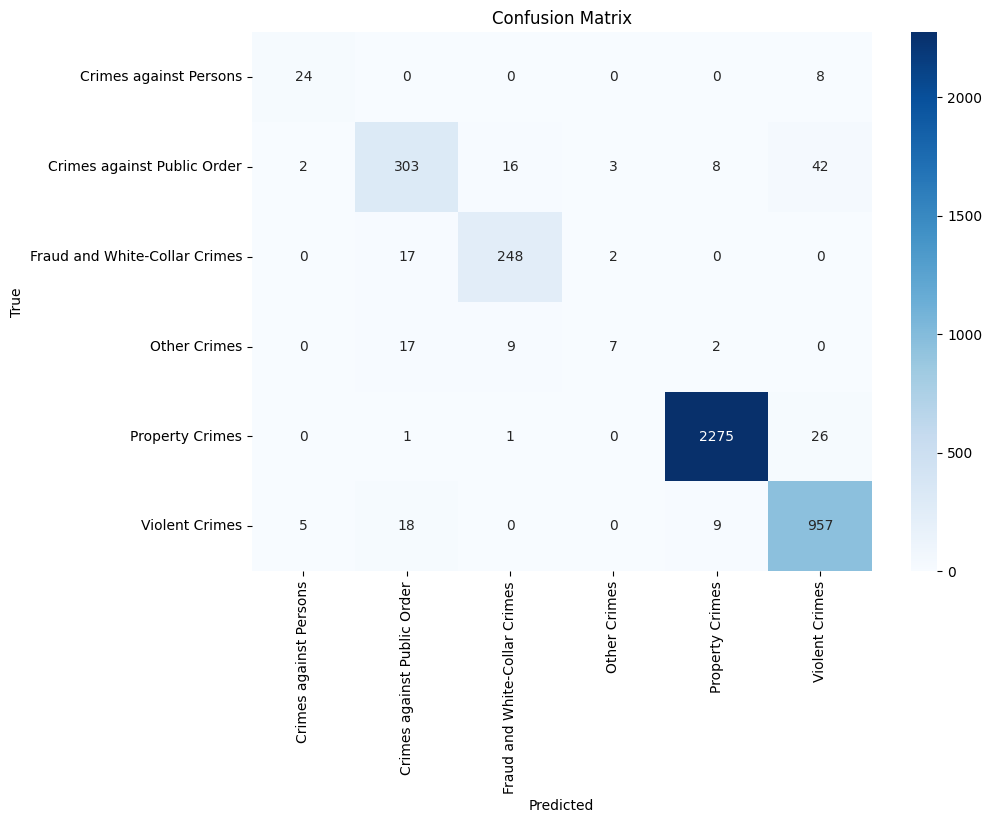

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.77      0.75      0.76        32
  Crimes against Public Order       0.85      0.81      0.83       374
Fraud and White-Collar Crimes       0.91      0.93      0.92       267
                 Other Crimes       0.58      0.20      0.30        35
              Property Crimes       0.99      0.99      0.99      2303
               Violent Crimes       0.93      0.97      0.95       989

                     accuracy                           0.95      4000
                    macro avg       0.84      0.77      0.79      4000
                 weighted avg       0.95      0.95      0.95      4000
 

Accuracy: 0.9535


In [56]:
X = pd.read_csv("Dataset/train.csv", sep = ';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# remove column with 80% null values
X = X.drop('Cross_Street', axis=1)

# handle missing data
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0) # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# data handling
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()

numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

def label_encoding_column(df, column):
    lab_encoder = LabelEncoder()
    df[column] = lab_encoder.fit_transform(df[column])
    return df

for col in categorical_columns:
  if col == 'Modus_Operandi':
    continue
  X = label_encoding_column(X, col)

modus_operandi_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    CountVectorizer(preprocessor=lambda x:x[0])
)

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
  ])

# 7. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Fit and transform the training data
X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

# Convert the transformed data back to dense if needed (LightGBM accetta sparse CSR, quindi non serve)
# Qui possiamo lasciare i dati in formato CSR.

# Encode target labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# 8. Create the LightGBM Dataset
train_set = lgb.Dataset(X_train_transformed, label=y_train_encoded)

# 9. Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_encoded)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# 10. Train the model with validation and early stopping
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
)

# 11. Predictions
y_pred_proba = bst.predict(X_test_transformed)  # Use transformed test set
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# 12. Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 13. Classification report (precision, recall, F1-score)
class_report = classification_report(y_test_encoded, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report, '\n')

# Accuracy
accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print("Accuracy: ", accuracy)

**LightGBM with one-hot-encoding**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:242: UserWarning: Found unknown categories in columns [0, 4, 5] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


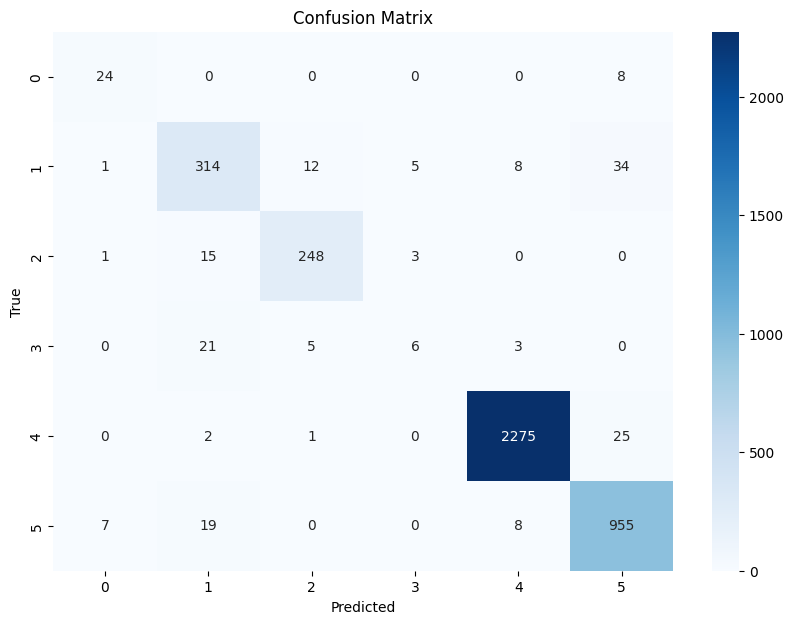

Classification Report:
              precision    recall  f1-score   support

           0       0.73      0.75      0.74        32
           1       0.85      0.84      0.84       374
           2       0.93      0.93      0.93       267
           3       0.43      0.17      0.24        35
           4       0.99      0.99      0.99      2303
           5       0.93      0.97      0.95       989

    accuracy                           0.96      4000
   macro avg       0.81      0.77      0.78      4000
weighted avg       0.95      0.96      0.95      4000
 

0.9555


In [55]:
# 1. Load the dataset
X = pd.read_csv("Dataset/train.csv", sep=';')
y = X['Crime_Category']
X = X.drop('Crime_Category', axis=1)

# 2. Remove column with 80% null values
X.drop('Cross_Street', axis=1, inplace=True)

# 3. Handle missing data
X['Victim_Sex'] = X['Victim_Sex'].replace(['H', 'X'], 'Unknown')
X['Victim_Descent'] = X['Victim_Descent'].fillna('Unknown')
X['Weapon_Description'] = X['Weapon_Description'].fillna('No Weapon')
X['Weapon_Used_Code'] = X['Weapon_Used_Code'].fillna(0)  # Weapon_Used_Code is in the range [1,3990], 0 is for missing code
X['Modus_Operandi'] = X['Modus_Operandi'].fillna('Unknown')

# 4. Handle date columns
X['Date_Reported'] = pd.to_datetime(X['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Date_Occurred'] = pd.to_datetime(X['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p', errors='coerce')
X['Year_Reported'] = X.Date_Reported.dt.year
X['Year_Occurred'] = X.Date_Occurred.dt.year
X['Month_Reported'] = X.Date_Reported.dt.month
X['Month_Occurred'] = X.Date_Occurred.dt.month
X['Day_Reported'] = X.Date_Reported.dt.day
X['Day_Occurred'] = X.Date_Occurred.dt.day
X.drop(['Date_Reported', 'Date_Occurred'], axis=1, inplace=True)

# 5. Separate numerical and categorical features
numerical_columns = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
categorical_columns = [col for col in categorical_columns if col != 'Modus_Operandi']

# 6. Pipelines for data preprocessing
numerical_pipeline = make_pipeline(
    SimpleImputer(strategy='median'),
    StandardScaler()
)

categorical_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    OneHotEncoder(handle_unknown='ignore', sparse_output=False, drop='first')
)

modus_operandi_pipeline = make_pipeline(
    SimpleImputer(strategy='most_frequent'),
    CountVectorizer(preprocessor=lambda x: x[0])
)

# 7. Preprocessor with ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_columns),
    ('cat', categorical_pipeline, categorical_columns),
    ('modus_operandi', modus_operandi_pipeline, ['Modus_Operandi'])
])

# 8. Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Encode target labels
y_encoder = LabelEncoder()
y_train_encoded = y_encoder.fit_transform(y_train)
y_test_encoded = y_encoder.transform(y_test)

# 9. Create the LightGBM Dataset
train_set = lgb.Dataset(preprocessor.fit_transform(X_train), label=y_train_encoded)

# 10. Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train_encoded)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# 11. Train the model with validation and early stopping
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
)

# 12. Predictions
y_pred_proba = bst.predict(preprocessor.transform(X_test))
y_pred_classes = np.argmax(y_pred_proba, axis=1)

# 13. Visualize the Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
print('\n')
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y_test_encoded), yticklabels=np.unique(y_test_encoded))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# 14. Classification report (precision, recall, f1-score)
class_report = classification_report(y_test_encoded, y_pred_classes)
print("Classification Report:")
print(class_report,'\n')

accuracy = accuracy_score(y_test_encoded, y_pred_classes)
print('Accuracy: ', accuracy)

**Nurbek**

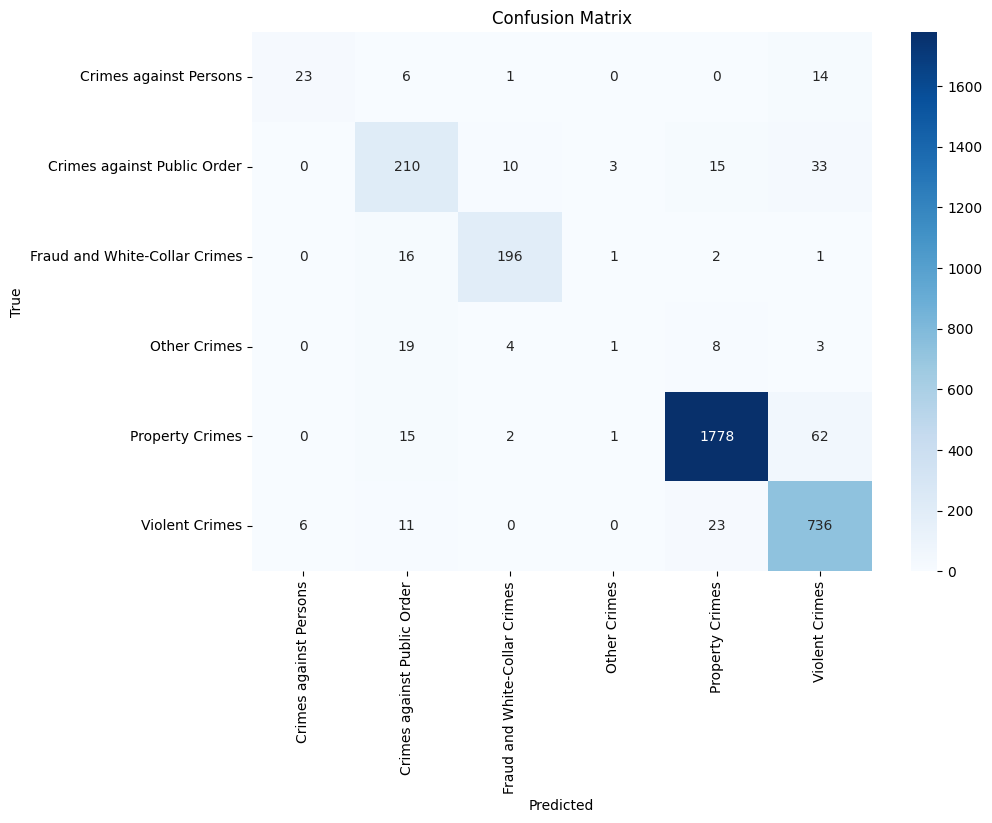

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.79      0.52      0.63        44
  Crimes against Public Order       0.76      0.77      0.77       271
Fraud and White-Collar Crimes       0.92      0.91      0.91       216
                 Other Crimes       0.17      0.03      0.05        35
              Property Crimes       0.97      0.96      0.97      1858
               Violent Crimes       0.87      0.95      0.91       776

                     accuracy                           0.92      3200
                    macro avg       0.75      0.69      0.71      3200
                 weighted avg       0.91      0.92      0.92      3200
 

Accuracy:  0.92


In [61]:
# Load datasets
train_df = pd.read_csv("Dataset/training.csv")
test_df = pd.read_csv("Dataset/test.csv")

# Step 1: Data preprocessing
# Encode the categorical target variable
label_encoder = LabelEncoder()
train_df['Crime_Category'] = label_encoder.fit_transform(train_df['Crime_Category'])

# Separate features and target variable
X = train_df.drop(columns=['Crime_Category'])
y = train_df['Crime_Category']

# Split features into numerical and categorical columns
numerical_columns = X.select_dtypes(include=['float64', 'int64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

# Handle missing values
X[numerical_columns] = X[numerical_columns].fillna(X[numerical_columns].median())
X[categorical_columns] = X[categorical_columns].fillna('Unknown')

# Convert categorical features to numeric
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col])
    label_encoders[col] = le

# Scale numerical features
scaler = StandardScaler()
X[numerical_columns] = scaler.fit_transform(X[numerical_columns])

# Step 2: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create the LightGBM Dataset
train_set = lgb.Dataset(X_train, label=y_train)

# Step 4: Model parameters (for multiclass classification)
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),  # Number of classes in the target
    'metric': 'multi_logloss',  # Metrics for classification
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# Step 5: Train the model
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
)

# Step 6: Predictions
y_pred_proba = bst.predict(X_test)  # Predicted probabilities
y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Convert probabilities to class predictions

# Step 7: Visualize the confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Step 8: Classification report (precision, recall, F1-score)
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report, '\n')

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy: ", accuracy)

**Chenjie**

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['0347', '0350', '0402', '0410', '0437', '0543', '0547', '0550', '0933', '0946', '1012', '1021', '1239', '1248', '1277', '1316', '1411', '1538', '2011', '2019'] will be ignored
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:900: UserWarning: unknown class(es) ['0347', '0350', '0402', '0410', '0437', '0543', '0547', '0550', '0933', '0946', '1012', '1021', '1239', '1248', '1277', '1316', '1411', '1538', '2011', '2019'] will be ignored
  warnings.warn(


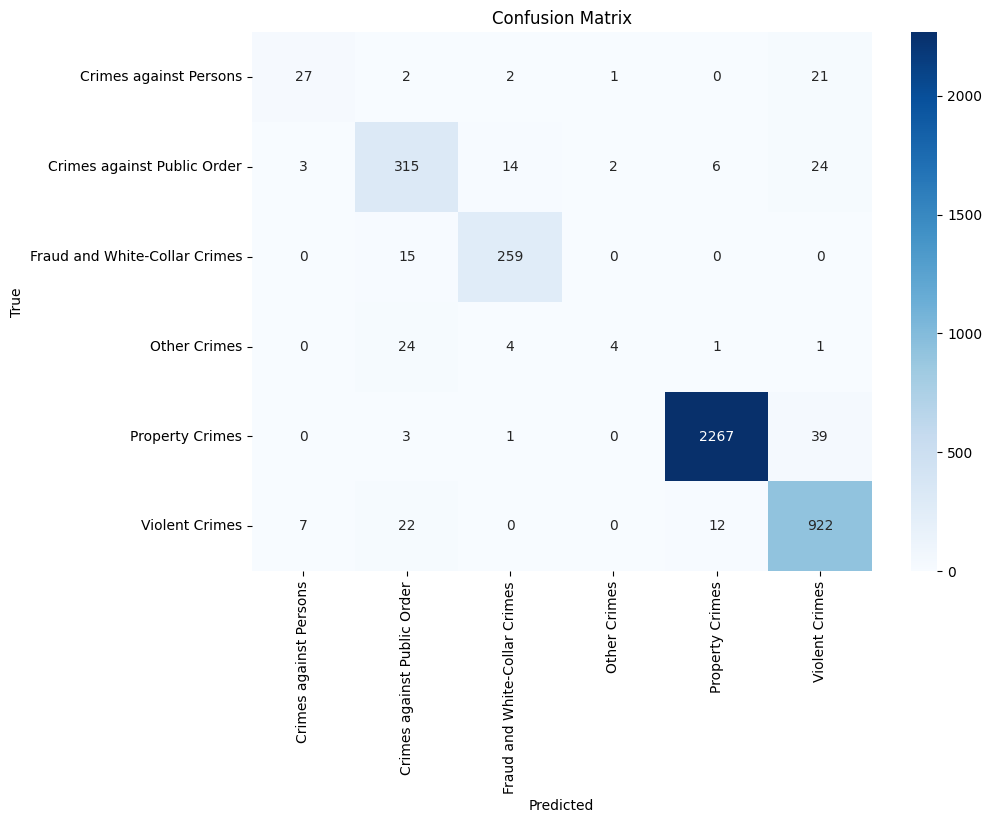

Classification Report:
                               precision    recall  f1-score   support

       Crimes against Persons       0.73      0.51      0.60        53
  Crimes against Public Order       0.83      0.87      0.85       364
Fraud and White-Collar Crimes       0.93      0.95      0.94       274
                 Other Crimes       0.57      0.12      0.20        34
              Property Crimes       0.99      0.98      0.99      2310
               Violent Crimes       0.92      0.96      0.94       963

                     accuracy                           0.95      3998
                    macro avg       0.83      0.73      0.75      3998
                 weighted avg       0.95      0.95      0.95      3998
 

Accuracy:  0.9489744872436218


In [80]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder,  StandardScaler, MinMaxScaler,MultiLabelBinarizer,LabelEncoder

# Step 1: Load and preprocess the dataset
train = pd.read_csv("Dataset/train.csv", sep=';')

# Remove duplicates and unnecessary columns
train = train.drop_duplicates()
train.drop('Cross_Street', axis=1, inplace=True)

# Handle missing values
train['Weapon_Used_Code'] = train['Weapon_Used_Code'].fillna(train['Weapon_Used_Code'].max() + 1)
mode_victim_sex_value = train['Victim_Sex'].mode().iloc[0]
train['Victim_Sex'] = train['Victim_Sex'].fillna(mode_victim_sex_value)
mode_victim_descent_value = train['Victim_Descent'].mode().iloc[0]
train['Victim_Descent'] = train['Victim_Descent'].fillna(mode_victim_descent_value)
mode_modus_operandi_value = train['Modus_Operandi'].mode().iloc[0]
train['Modus_Operandi'] = train['Modus_Operandi'].fillna(mode_modus_operandi_value)
train['Modus_Operandi'] = train['Modus_Operandi'].apply(lambda x: str(x).split(" ") if x else [])

# Convert dates and extract time-based features
train['Date_Reported'] = pd.to_datetime(train['Date_Reported'], format='%m/%d/%Y %I:%M:%S %p')
train['Date_Occurred'] = pd.to_datetime(train['Date_Occurred'], format='%m/%d/%Y %I:%M:%S %p')
train['Year_Reported'] = train['Date_Reported'].dt.year
train['Month_Reported'] = train['Date_Reported'].dt.month
train['Day_Reported'] = train['Date_Reported'].dt.day
train['Year_Occurred'] = train['Date_Occurred'].dt.year
train['Month_Occurred'] = train['Date_Occurred'].dt.month
train['Day_Occurred'] = train['Date_Occurred'].dt.day
train['Time_Occurred'] = train['Time_Occurred'].apply(lambda x: int(x // 100))

# Encode target variable
label_encoder = LabelEncoder()
train['Crime_Category'] = label_encoder.fit_transform(train['Crime_Category'])

# Drop less relevant columns
train.drop(columns=['Year_Occurred'], inplace=True)

# Convert specific columns to integer type
columns_to_convert = ['Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Victim_Age', 'Premise_Code', 'Weapon_Used_Code']
train[columns_to_convert] = train[columns_to_convert].astype(int)

# Select relevant columns
included_columns = ['Location', 'Latitude', 'Longitude', 'Area_ID', 'Reporting_District_no', 'Part 1-2', 'Modus_Operandi',
                    'Victim_Age', 'Victim_Sex', 'Victim_Descent', 'Premise_Code', 'Weapon_Used_Code', 'Status',
                    'Crime_Category', 'Year_Reported', 'Month_Reported', 'Day_Reported', 'Month_Occurred', 'Day_Occurred']
new_train = train[included_columns]

# Separate features and target
X = new_train.drop('Crime_Category', axis=1)
y = new_train['Crime_Category']

# Step 2: Split dataset into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Step 3: Create custom transformer for MultiLabelBinarizer
class MultiLabelBinarizerTransformer(BaseEstimator, TransformerMixin):
    def __init__(self):
        self.ml_binarizers = {}

    def fit(self, X, y=None):
        for column in X.columns:
            mlb = MultiLabelBinarizer()
            mlb.fit(X[column])
            self.ml_binarizers[column] = mlb
        return self

    def transform(self, X):
        X_transformed = []
        for column in X.columns:
            mlb = self.ml_binarizers[column]
            transformed_data = mlb.transform(X[column])
            transformed_df = pd.DataFrame(
                transformed_data, columns=[f"{column}_{cls}" for cls in mlb.classes_]
            )
            X_transformed.append(transformed_df)
        return pd.concat(X_transformed, axis=1)

# Step 4: Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('one_hot_encoder', OneHotEncoder(handle_unknown='ignore'), ['Area_ID', 'Reporting_District_no', 'Part 1-2', 'Victim_Sex',
                                                                      'Victim_Descent', 'Premise_Code', 'Weapon_Used_Code', 'Status',
                                                                      'Location']),
        ('minmax_scaler', MinMaxScaler(), ['Latitude', 'Longitude', 'Victim_Age']),
        ('modus_operandi', MultiLabelBinarizerTransformer(), ['Modus_Operandi'])
    ],
    remainder='passthrough'
)

# Trasforma i dati preprocessati e converti in DataFrame
X_train_preprocessed = preprocessor.fit_transform(X_train)
X_test_preprocessed = preprocessor.transform(X_test)

# LightGBM non accetta array non numerici. Convertiamo in DataFrame con colonne numeriche.
X_train_preprocessed = pd.DataFrame(X_train_preprocessed)
X_test_preprocessed = pd.DataFrame(X_test_preprocessed)

X_train_preprocessed = pd.DataFrame(
    preprocessor.fit_transform(X_train).toarray()
)
X_test_preprocessed = pd.DataFrame(
    preprocessor.transform(X_test).toarray()
)

# Rimuoviamo eventuali colonne non numeriche
X_train_preprocessed = X_train_preprocessed.select_dtypes(include=['int64', 'float64', 'bool'])
X_test_preprocessed = X_test_preprocessed.select_dtypes(include=['int64', 'float64', 'bool'])

# Assicuriamoci che tutti i dati siano di tipo float
X_train_preprocessed = X_train_preprocessed.astype(float)
X_test_preprocessed = X_test_preprocessed.astype(float)

# Creiamo il dataset di LightGBM
train_set = lgb.Dataset(X_train_preprocessed, label=y_train)
test_set = lgb.Dataset(X_test_preprocessed, label=y_test, reference=train_set)

# Parametri del modello
params = {
    'objective': 'multiclass',
    'num_class': len(np.unique(y_train)),  # Numero di classi
    'metric': 'multi_logloss',
    'learning_rate': 0.05,
    'max_depth': 6,
    'num_leaves': 31,
    'boosting_type': 'gbdt',
    'verbose': -1,
    'feature_fraction': 0.8
}

# Addestramento del modello
bst = lgb.train(
    params,
    train_set,
    num_boost_round=100,
    valid_sets=[train_set, test_set]
)

# Predizioni
y_pred_proba = bst.predict(X_test_preprocessed)  # Probabilità predette
y_pred_classes = np.argmax(y_pred_proba, axis=1)  # Predizione finale

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(10, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_encoder.classes_,
            yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
class_report = classification_report(y_test, y_pred_classes, target_names=label_encoder.classes_)
print("Classification Report:")
print(class_report, '\n')

# Accuracy
accuracy = accuracy_score(y_test, y_pred_classes)
print("Accuracy: ", accuracy)